<a href="https://colab.research.google.com/github/Zardian18/FashionMnist-Autoencoders/blob/master/VAE_fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2024-01-02 21:13:56--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13084 (13K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  12.78K  --.-KB/s    in 0.001s  

2024-01-02 21:13:57 (24.4 MB/s) - ‘helper.py’ saved [13084/13084]



In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K

In [3]:
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var= inputs
    batch= tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5*z_log_var)*epsilon

In [4]:
from helper import display

In [5]:
from tensorflow.keras import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
(x_train, y_train), (x_test, y_test)= datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [7]:
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [8]:
x_train.shape

(60000, 32, 32, 1)

In [36]:
encoder_input = layers.Input(shape=(32,32,1), name="encoder_input")
x= layers.Conv2D(32, 3, 2, activation="relu", padding="same")(encoder_input)
x= layers.Conv2D(64, 3, 2, activation="relu", padding="same")(x)
x= layers.Conv2D(128, 3, 2, activation="relu", padding="same")(x)
shape_before_flatten= x.shape[1:]

x= layers.Flatten()(x)
z_mean = layers.Dense(2, name="z_mean")(x)
z_log_var= layers.Dense(2, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder= tf.keras.models.Model(encoder_input, [z_mean, z_log_var,z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_16 (Conv2D)          (None, 8, 8, 64)             18496     ['conv2d_15[0][0]']           
                                                                                                  
 conv2d_17 (Conv2D)          (None, 4, 4, 128)            73856     ['conv2d_16[0][0]']           
                                                                                            

In [22]:
decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flatten))(decoder_input)
x = layers.Reshape(shape_before_flatten)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = tf.keras.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 8, 8, 128)         147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 32, 32, 32)        1846

In [23]:
shape_before_flatten

TensorShape([4, 4, 128])

In [24]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    @tf.function
    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                500
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            500
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [37]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

In [38]:
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [40]:
vae.fit(
    x_train,
    epochs=5,
    batch_size=100,
    shuffle=True
)

Epoch 1/5
600/600 [==============================] - 213s 354ms/step - total_loss: 159.1422 - reconstruction_loss: 154.8280 - kl_loss: 4.3141
Epoch 2/5
600/600 [==============================] - 209s 349ms/step - total_loss: 136.2828 - reconstruction_loss: 131.4559 - kl_loss: 4.8268
Epoch 3/5
600/600 [==============================] - 214s 356ms/step - total_loss: 134.2879 - reconstruction_loss: 129.3119 - kl_loss: 4.9760
Epoch 4/5
600/600 [==============================] - 211s 352ms/step - total_loss: 133.3180 - reconstruction_loss: 128.2645 - kl_loss: 5.0535
Epoch 5/5
600/600 [==============================] - 210s 350ms/step - total_loss: 132.6874 - reconstruction_loss: 127.5876 - kl_loss: 5.0998


In [41]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 8s 50ms/step
Example real clothing items


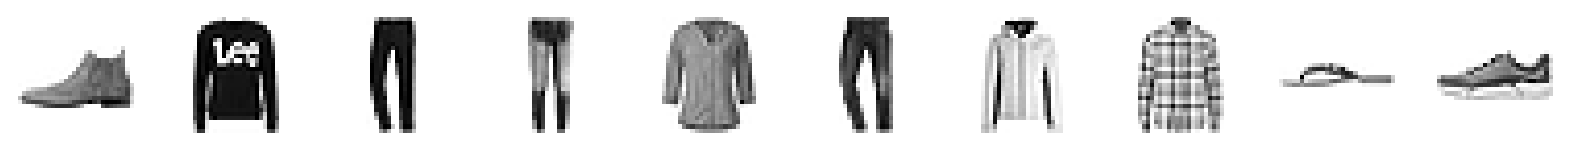

Reconstructions


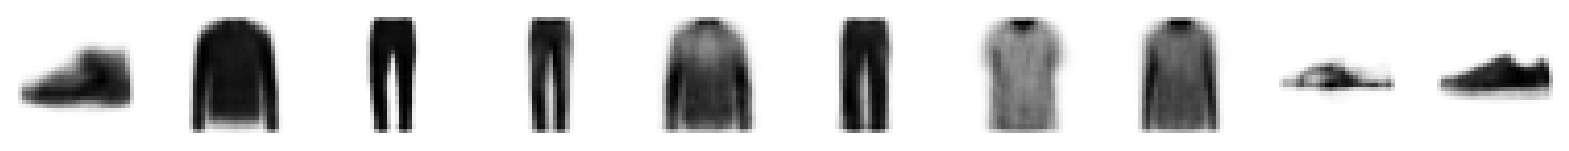

In [42]:
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

In [45]:
z_log_var.shape

(5000, 2)

In [46]:
z.shape

TensorShape([None, 2])

In [47]:
z_mean,z_log_var, z = encoder.predict(example_images)

157/157 [==============================] - 2s 10ms/step


In [48]:
z[:10]

array([[-0.6618838 ,  1.1302254 ],
       [ 1.8256445 , -0.47587302],
       [-0.8485825 , -3.6204998 ],
       [-1.2265673 , -1.2284106 ],
       [ 0.44692305, -0.08286314],
       [-0.5268629 , -2.113442  ],
       [-0.42700276, -0.17598222],
       [ 0.15513863, -0.13502282],
       [-1.9612691 ,  0.44731373],
       [-1.7779319 ,  0.8544047 ]], dtype=float32)

In [49]:
z_mean[:10]

array([[-0.63808113,  1.0945227 ],
       [ 1.5583163 , -0.4115403 ],
       [-0.89249814, -2.8733385 ],
       [-1.1982967 , -1.3842094 ],
       [ 0.4408873 , -0.01424748],
       [-0.5182767 , -1.8812069 ],
       [-0.37454957, -0.19098909],
       [ 0.15577757, -0.10852334],
       [-1.977449  ,  0.2020958 ],
       [-1.8024893 ,  0.8324155 ]], dtype=float32)

In [50]:
z_log_var[:10]

array([[-5.608748 , -4.991603 ],
       [-4.728819 , -6.296468 ],
       [-4.3845563, -2.5624373],
       [-4.670619 , -4.051549 ],
       [-4.6136527, -5.4624624],
       [-4.7417207, -3.601991 ],
       [-5.457343 , -6.0990567],
       [-4.8740783, -5.969636 ],
       [-3.6951358, -5.275135 ],
       [-3.8351529, -4.560237 ]], dtype=float32)

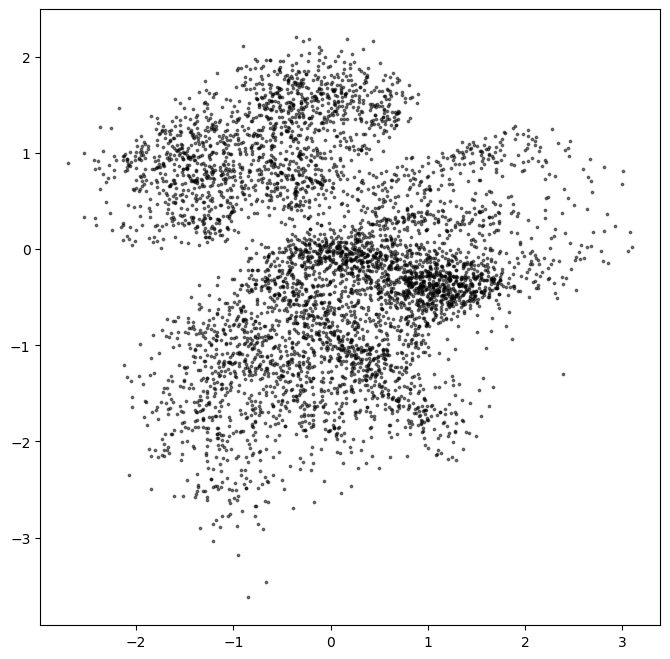

In [51]:
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [52]:
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 283ms/step


In [54]:
from scipy.stats import norm

In [55]:
p=norm.cdf(z)
p

array([[2.54022857e-01, 8.70809374e-01],
       [9.66048085e-01, 3.17082421e-01],
       [1.98056822e-01, 1.47017211e-04],
       ...,
       [7.76706543e-01, 9.36536282e-01],
       [3.88993531e-01, 1.33025644e-01],
       [1.12665538e-02, 8.09867198e-01]])

In [56]:
z

array([[-0.6618838 ,  1.1302254 ],
       [ 1.8256445 , -0.47587302],
       [-0.8485825 , -3.6204998 ],
       ...,
       [ 0.76111746,  1.5263311 ],
       [-0.2819432 , -1.112202  ],
       [-2.2812593 ,  0.877407  ]], dtype=float32)

In [57]:
p_sample= norm.cdf(z_sample)
p_sample

array([[0.23437978, 0.44368007],
       [0.71597079, 0.02196243],
       [0.33095794, 0.91756849],
       [0.83802058, 0.65391852],
       [0.22243865, 0.05167132],
       [0.80378789, 0.47084141],
       [0.68338138, 0.79566481],
       [0.94556853, 0.55071642],
       [0.87161478, 0.04050624],
       [0.44550548, 0.1702837 ],
       [0.99136446, 0.65215647],
       [0.51094599, 0.63748512],
       [0.93309638, 0.91369962],
       [0.72652519, 0.69607751],
       [0.35681609, 0.52621165],
       [0.44332176, 0.94905328],
       [0.2117418 , 0.87006857],
       [0.3585182 , 0.85908828]])

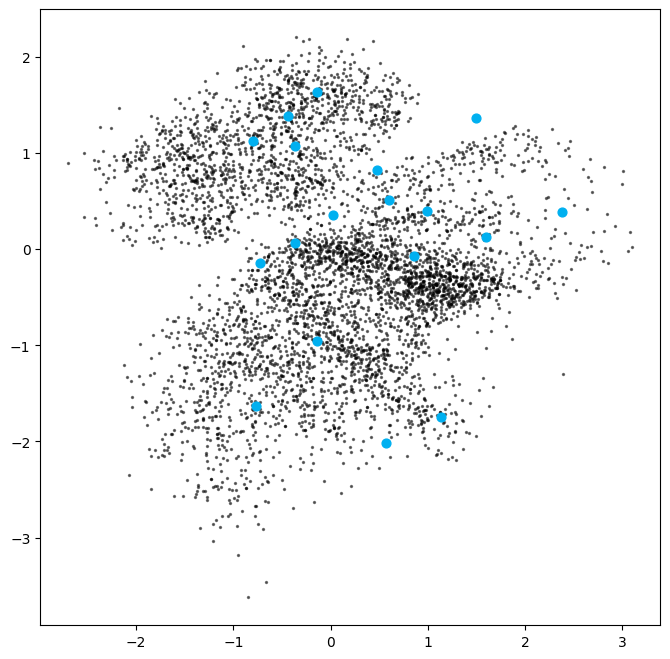

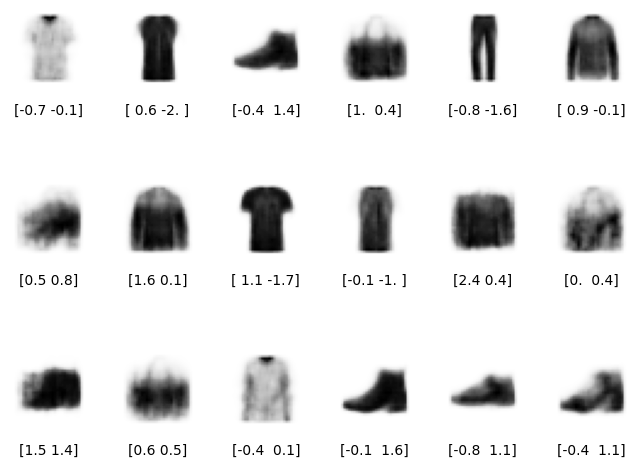

In [58]:
figsize = 8
plt.figure(figsize=(figsize, figsize))

plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()


fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

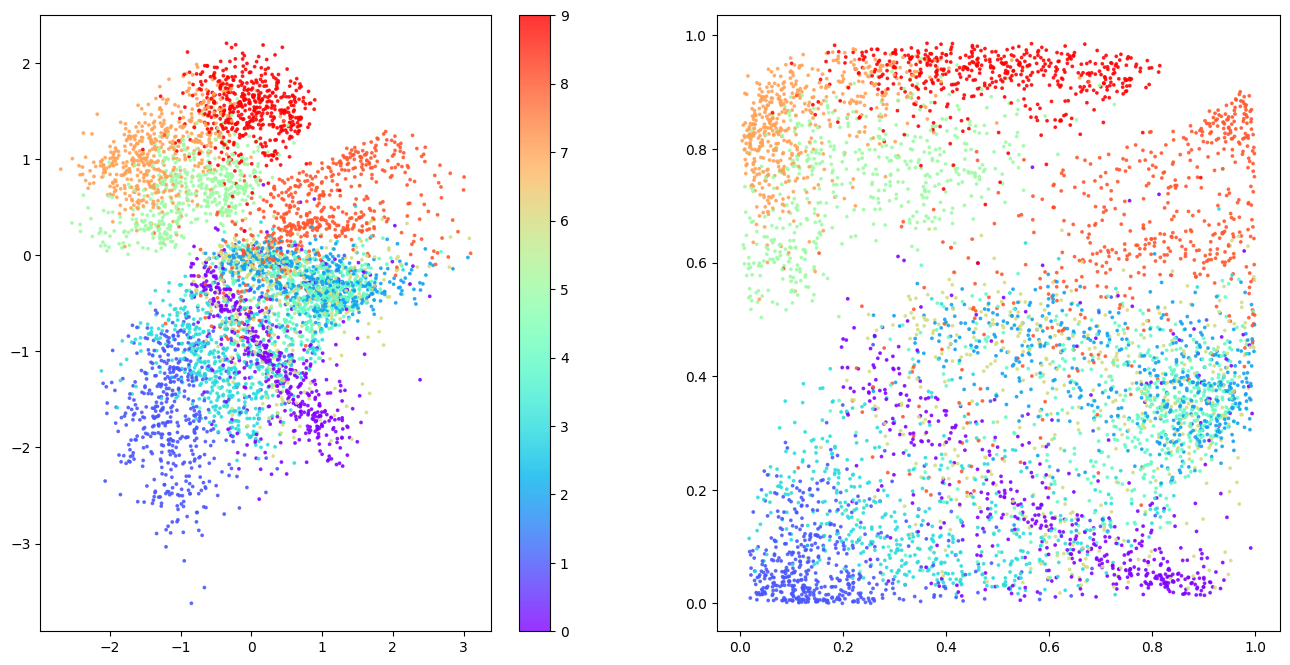

In [59]:
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

8/8 [==============================] - 0s 54ms/step


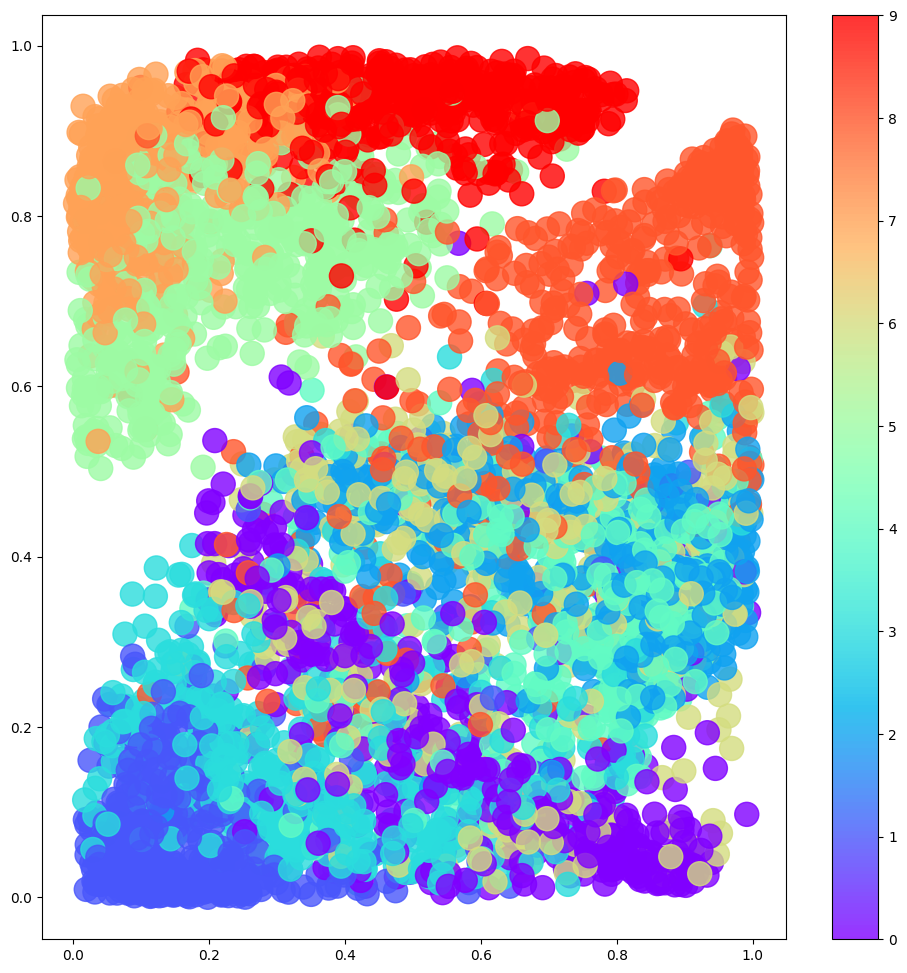

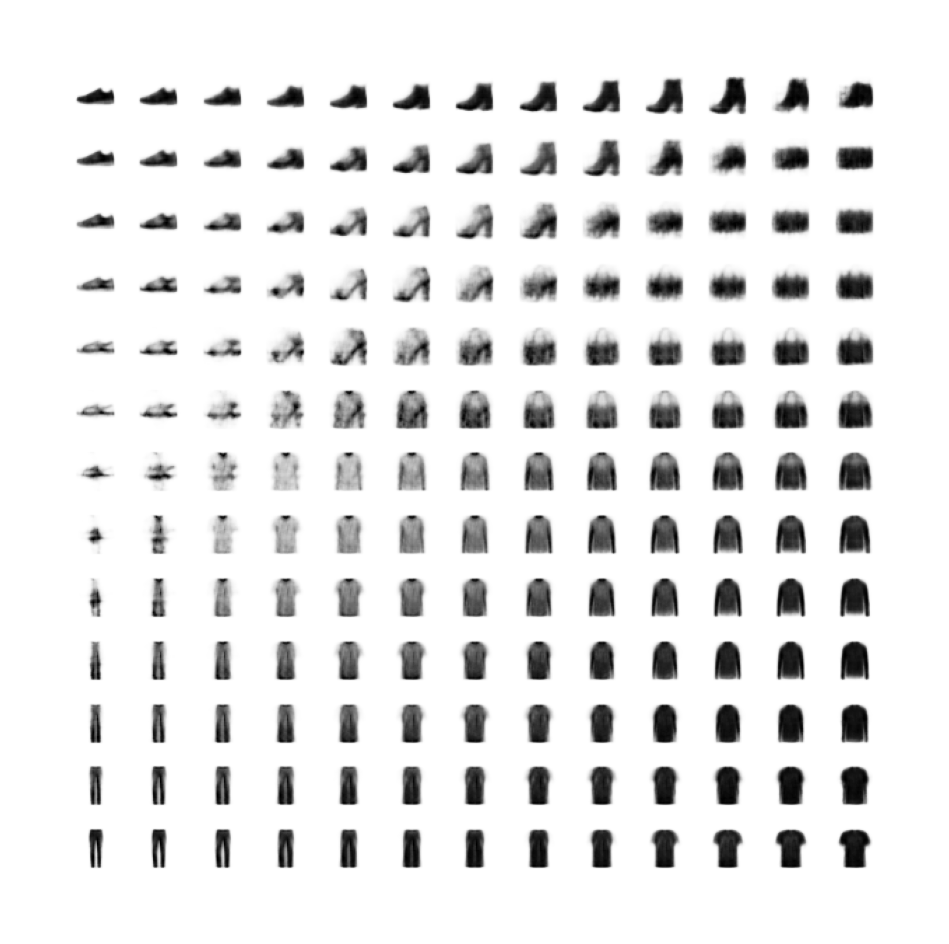

In [60]:
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")